# Lab 7 Report: Dylan Jones
## German-to-English Translation with Attention-Mechanism Transformer Model

In [44]:
# !pip install torchtext
# import locale
# def getpreferredencoding(do_setlocale = True):
#     return "UTF-8"
# locale.getpreferredencoding = getpreferredencoding
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [45]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Initialize your numpy and pytorch random seeds for reproducibility 
np.random.seed(0)
torch.manual_seed(0)
# Create a torch.device object to tell pytorch where to store your tensors: cpu or gpu
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [47]:
# Image('lab7_exercise.png', width = 1000)

In [48]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Download data

In [49]:
# Load the data and store it as a list of tuples: each element in the list should be a tuple of the form (german_sentence, english_sentence)
data_pairs = []
with open('de_to_en.txt', "r", encoding="utf-8") as f:
  lines = f.read().split("\n")

for line in lines:
  appendage = line.split('\t')
  data_pairs.append(appendage)


## Let's see what the data looks like

In [50]:
# Print the first ten translated lines
for i in range(10):
  print(data_pairs[i][0], data_pairs[i][1])

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche. Two young, White males are outside near many bushes.
Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem. Several men in hard hats are operating a giant pulley system.
Ein kleines Mädchen klettert in ein Spielhaus aus Holz. A little girl climbing into a wooden playhouse.
Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster. A man in a blue shirt is standing on a ladder cleaning a window.
Zwei Männer stehen am Herd und bereiten Essen zu. Two men are at the stove preparing food.
Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht. A man in green holds a guitar while the other man observes his shirt.
Ein Mann lächelt einen ausgestopften Löwen an. A man is smiling at a stuffed lion
Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt. A trendy girl talking on her cellphone while gliding slowly down the street.
Eine Frau mit einer g

## Create source and target language tokenizers

But first, what exactly is a *tokenizer*?

A short but incomplete summary is that a tokenizer converts your text/string into a list of numerical values (a list of *tokens*). We performed tokenization in Lab 5 when we converted each alphanumeric character in our text into a number (an index in a dictionary). 

Here, the tokenization is a bit different. Instead of converting each *character* into a number, we want to convert each *word* into a number. As you can imagine, this means the vocabulary of our dataset - the set of unique tokens it contains - will be much larger. There are many more words in English than there are letters! This also means the value of each token will be more unique and meaningful.

Part of tokenizing at the word level is the process of standardizing the text by converting it to lowercase, removing punctuation or special characters, and dealing with contractions or other language-specific features. This is sometimes called *stemming*, reflecting the fact that we want to only extract the *essential meaning* of each word - the "stem" - not necessarily the punctuation, prefixes, suffixes, etc. surrounding it.

Luckily for us, there are some existing Python packages that do this automatically. The below cell downloads two different tokenizers (one each for the source and larget languages), and assigns them to appropriate keys within the "token_transform" dictionary. 
In Lab 5, you performed tokenization when you converted each character of the text into a specific number.

In [51]:
# Define MACRO - a high-level variable that won't change throughout the duration of the code - for your source and target languages
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'


# Download the German and English tokenizers, and assign them to appropriate keys in your token_transform dictionary
en_token_transform = get_tokenizer('spacy', language='en_core_web_sm')
de_token_transform = get_tokenizer('spacy', language='de_core_news_sm')

token_transform = {}
token_transform[SRC_LANGUAGE] = en_token_transform
token_transform[TGT_LANGUAGE] = de_token_transform





## Let's see what these specific tokenizers do.

In [52]:
# Tokenize the first line of each dataset, and print the tokenized version of it
en_0_tokenized = token_transform[SRC_LANGUAGE](data_pairs[0][1]) 
de_0_tokenized = token_transform[TGT_LANGUAGE](data_pairs[0][0]) 

print(en_0_tokenized) 
print(de_0_tokenized)

['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'im', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.']


## Create a vocabulary for each language's dataset

In Lab 5, we did this with a simple dictionary that mapped each character to an integer (and vice versa). However, PyTorch has a built-in dictionary object that provides some extra functionality. 

We will create this object using torchtext.data.build_vocab_from_iterator(). This function takes an iterator as input and returns a torchtext.vocab.Vocab object. This is a dictionary-like object that maps tokens to indices, but where it differs from a normal dictionary, is that its indices are assigned based on the frequency of the tokens in the dataset. For example, the most frequent token gets the index 0, the second most frequent gets the index 1, and so on. This frequency-index mapping saves a bunch of compute time and resources. 


Moreover, this time we will also have the four "special" tokens, that will always be assigned to the first four indices.

In [53]:
# Define a helper function that converts a list of strings into a list of lists-of-tokens

def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        try:
          yield token_transform[language](data_sample[language_index[language]])
        except IndexError:
          print(f"token_transform.keys(): {token_transform.keys()}")
          print(f"language: {language}")
          print(f"data_sample: {data_sample}")
          print(f"language_index: {language_index}")
          raise IndexError

# Define your special tokens and their indeces in your vocabulary
special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']

# Define your vocabulary for each language using the build_vocab_from_iterator function
vocab_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Invoke torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(data_pairs, ln),
                                                    min_freq=1,
                                                    specials=special_tokens,
                                                    special_first=True)

# Set ``UNK_IDX`` as the default index. 
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

# Let's see the first 20 words in each vocabulary
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

# Let's see the first 20 words in each vocabulary
print(vocab_transform[SRC_LANGUAGE].get_itos()[:20])
print(vocab_transform[TGT_LANGUAGE].get_itos()[:20])

['<unk>', '<pad>', '<bos>', '<eos>', '.', 'Ein', 'einem', 'in', 'und', ',', 'mit', 'auf', 'Mann', 'einer', 'Eine', 'ein', 'der', 'Frau', 'eine', 'die']
['<unk>', '<pad>', '<bos>', '<eos>', 'a', '.', 'A', 'in', 'the', 'on', 'is', 'and', 'man', 'of', 'with', ',', 'woman', 'are', 'to', 'Two']


## Train-Validate-Test split

In [54]:
# Shuffle the text pairs
shuffler = np.random.permutation(len(data_pairs))
data_pairs = [data_pairs[i] for i in shuffler]

# Let's go for a 70-20-10 train-val-test split
n_train = int(0.7*len(data_pairs))
train_pairs = data_pairs[:n_train] 

n_val = int(0.2*len(data_pairs))
val_pairs = data_pairs[n_train:n_train+n_val]

n_test = int(0.1*len(data_pairs))
test_pairs = data_pairs[n_train+n_val:]

print(f"{len(data_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

31019 total pairs
21713 training pairs
6203 validation pairs
3103 test pairs


### Mask functions

The mask function plays an essential role in the training of a transformer model, specifically during the pre-training phase when the model learns to understand and generate language. The two main purposes of the mask function are:

1. To facilitate self-attention mechanism: Transformers use self-attention mechanisms to identify relationships between words in a sequence. Masking is used to prevent the model from "cheating" by looking at future tokens when trying to predict the current token. In other words, the mask function ensures that the model only attends to the current token and the previous tokens, not the future tokens, during the training process.

2. To enable masked language modeling (MLM): Masked language modeling is a popular pre-training objective used in transformer-based models like BERT. In MLM, a certain percentage of input tokens are randomly masked (usually around 15%), and the model is tasked with predicting the original tokens at these masked positions. The mask function serves as a way of hiding the original token from the model, forcing it to learn contextual representations that can help it predict the masked tokens accurately.

The use of the mask function in both self-attention and MLM helps the transformer model learn meaningful context-dependent representations, making it more effective at understanding and generating natural language.

In [55]:
# Define your masking function
def generate_square_subsequent_mask(sz): 
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Mask function
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Collation

The collation function is what converts our strings into batches of tensors that can be processed by our model, based on the vocabularies and tokenization functions we have built up thus far. 

Again, this is something we can do manually, but at some point the data transformations get so complicated that we might as well put them all into a function. Moreover, defining our transformation as a *function* allows us to use some more built-in PyTorch functionality that makes our jobs a whole lot easier. See: torch.utils.data.DataLoader. 

In [56]:
# Define helper function to club together sequential operations
def sequential_transforms(*transforms): 
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Define function to add BOS/EOS and create a tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# Define your ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {} 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# Define your "collation" function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

# Define training, evaluation functions

Modularization is the name of the game.

Not only does this help us here, but if you ever need to train a similar model in the future, you can simply import the ones defined here! 

For example, imagine this was a Python script and not a notebook, and the filename was "german_to_english_transformer.py" Then, in whichever future script or notebook you wish to use these functions, you could simply call:
"from german_to_english_transformer import train_epoch, evaluate"

In [57]:
# Define a function to train the model for a single epoch
def train_epoch(model, optimizer):
    model.train()
    loss_list = []
    train_iter = train_pairs
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        # Since we're training, recall we need to mask our input
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        # What do you think the model does with the masks when it's in evaluation mode?
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        loss_list.append(loss.item())

    return loss_list
# Define a function to evaluate the model
# Evaluates the model
def evaluate(model):
    model.eval()
    loss_list = []

    val_iter = val_pairs
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss_list.append(loss.item())

    return loss_list

## Define model

In [58]:
# Define the PositionalEncoding module that quantifies the relative position of words in a sentence
# Notice that this is not actually an MLP or neural network, i.e. it has no learned parameters
# it is just a function that you could represent analytically, if you wanted to
class PositionalEncoding(nn.Module): # <-- "Embedding"
    def __init__(self, emb_size, dropout, maxlen = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# Define the TokenEmbedding module converts a tensor of vocabulary-indices into a tensor of token-embeddings
# Also not a neural network, but a lookup table
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)
# Define the actual transformer model
# Question: What are we "transforming" between?
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 num_decoder_layers,
                 embedding_size,
                 num_heads,
                 src_vocab_size,
                 tgt_vocab_size,
                 dim_feedforward = 512,
                 dropout = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=embedding_size,
                                       nhead=num_heads,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(embedding_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, embedding_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(
            embedding_size, dropout=dropout)

    def forward(self,
                src,
                trg,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src)) # source sequence --> token embedding --> positional encoding
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg)) # target sequence --> token embedding --> positional encoding
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
# Question: What are we "transforming" between?

# The transformer 'transforms' tokens between the input embedding to the output embedding, in this
# case english to german embedding.  


## Question #2: What's the significance of the "num_heads" parameter in the __init__ function of the Seq2SeqTransformer above?

The num heads parameter determines the number of attention heads the transformer uses. This allows parallel computation of the attention mechanism and allows the model to learn more complex relationsips between words in the sequence. 

## Question #3: In less detail, state the significance of these other two parameters:

1. embedding_size: the number of expected features in input of the encoder and decoder
2. src_vocab_size: how many tokens are in the source langauge (number of words)

## Define hyperparameters

In [59]:
# Define your hyperparameters
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE]) 
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NUM_HEADS = 8 # Why 8? What do you expect to happen if we increase this parameter?
FFN_HID_DIM = 512 
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 6

# Define your model, loss function, and optimizer
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NUM_HEADS, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## Identify tracked values

In [60]:
train_loss_list = []
val_loss_list = []

## Train the model

In [61]:
# Train your model
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_loss_list.extend(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_list.extend(val_loss)
    print((f"Epoch: {epoch}, Epoch time = {(end_time - start_time):.3f}s"))

# Fair warning: you might get an "out of memory" error
# If that happens, try reducing the batch size

Epoch: 1, Epoch time = 34.706s
Epoch: 2, Epoch time = 35.428s
Epoch: 3, Epoch time = 34.930s
Epoch: 4, Epoch time = 35.180s
Epoch: 5, Epoch time = 35.102s
Epoch: 6, Epoch time = 35.134s


## Visualize and Evaluate the model

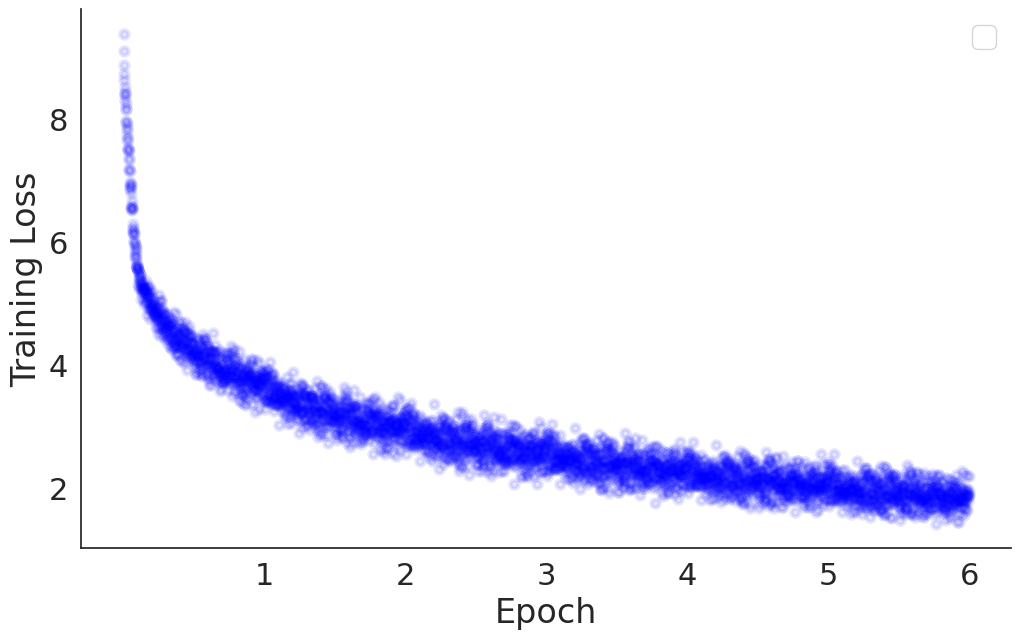

In [62]:
# Plot the loss
plt.figure(figsize = (12, 7))

plt.scatter(range(len(train_loss_list)), train_loss_list, color = 'blue', linewidth = 3, alpha=0.1)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.xticks(ticks = [(i+1)*len(train_loss_list)//NUM_EPOCHS for i in range(NUM_EPOCHS)], labels=[f"{i+1}" for i in range(NUM_EPOCHS)])
plt.legend()
sns.despine()

In [63]:
# Define a decode function to generate output sequence using greedy algorithm
# This basically saves us some compute time by taking a bunch of shortcuts (e.g. not computing the full softmax)
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

# Define a translation function that actually uses the model to translate a sentence from source to target
def translate(model, src_sentence):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

## Let's try the model out on a few of our test sequences. Print the first 10 target/translated sequences from our test set

In [64]:
for i in range(10):
    test_pair = test_pairs[-i]
    test_str_de = test_pair[0]
    test_str_en = test_pair[1]
    print(f"Target: {test_str_en}")
    print("Model output:", translate(transformer, test_str_de))
    print("")

Target: A group of faithful shoppers bear the cold while one points to his favorite store.
Model output:  A group of people are digging the same or in a parade while a crowd is showing his board . 

Target: I think the construction work is going on here.
Model output:  An athlete , dressed , including the dirt track . 

Target: A motorcyclist speeding along a road on a green Kawasaki sport motorcycle.
Model output:  A motorcycle rider riding a green trail in a green area . 

Target: Skater boy does a trick and gets his photo taken in midair.
Model output:  A team of a trick and is being getting ready to take a picture . 

Target: People rock climbing and hiking near a lake.
Model output:  A mountain biker and hiker near a lake . 

Target: A man and woman are in the kitchen and a package of Challenge butter is in the foreground.
Model output:  A man and woman in the kitchen , one is standing in the foreground , and is standing in the foreground . 

Target: A white man is seen in a swimm